In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense
# from tensorflow.kernas.regularizers import l2
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [26]:
df = pd.read_csv('stock_features.csv', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
target ='close'
features = df.drop(columns=['date', target]).values
X = features.copy()
y = df[target].copy().values.reshape(-1, 1)

In [ ]:
params = {
    'units': 64,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 100,
    'd_model': 64,
    'num_layers': 2,
    'ff_dim': 64,
    'num_heads': 2

}
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X)
y_train_scaled = scaler_y.fit_transform(y)

# 创建输入序列和标签，使用滑动窗口
def create_sequneces(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
X_train, y_train = create_sequneces(X_train_scaled, y_train_scaled)

print("划分数据集...")
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, shuffle=False)
X_val,X_test, y_val,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=False)

print("构建LSTM模型...")


model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate= 0.0001), loss='mean_squared_error', metrics=['mae'])
model.summary()
print("训练模型...")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

print("预测模型...")
predictions = model.predict(X_test)

predicted_prices =  scaler_y.inverse_transform(predictions)
real_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1))

"""模型验证和评估"""
print("评估模型...")
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {mse}")
print(f"Mean Absolute Error (MAE): {mse}")
print(f"R-squared (R2): {r2}")



划分数据集...
构建LSTM模型...


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 24, 64)         │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,945 (230.25 KB)

 Trainable params: 58,945 (230.25 KB)

 Non-trainable params: 0 (0.00 B)

训练模型...
Epoch 1/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - loss: 0.0038 - mae: 0.0370 - val_loss: 8.0281e-05 - val_mae: 0.0081
Epoch 2/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 6.4407e-04 - mae: 0.0167 - val_loss: 4.6031e-05 - val_mae: 0.0059
Epoch 3/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 58s 21ms/step - loss: 4.9056e-04 - mae: 0.0139 - val_loss: 2.8276e-05 - val_mae: 0.0044
Epoch 4/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - loss: 4.2936e-04 - mae: 0.0128 - val_loss: 3.8382e-05 - val_mae: 0.0054
Epoch 5/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 50s 18ms/step - loss: 3.9887e-04 - mae: 0.0123 - val_loss: 3.0750e-04 - val_mae: 0.0169
Epoch 6/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 56s 20ms/step - loss: 3.8662e-04 - mae: 0.0123 - val_loss: 3.2575e-05 - val_mae: 0.0047
Epoch 7/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - loss: 3.4203e-04 - mae: 0.0117 - val_loss: 8.8224e-06 - val_mae: 0.0023
Epoch 8/20
2822/2822 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step - loss: 3.3275e-04 - mae: 0.01

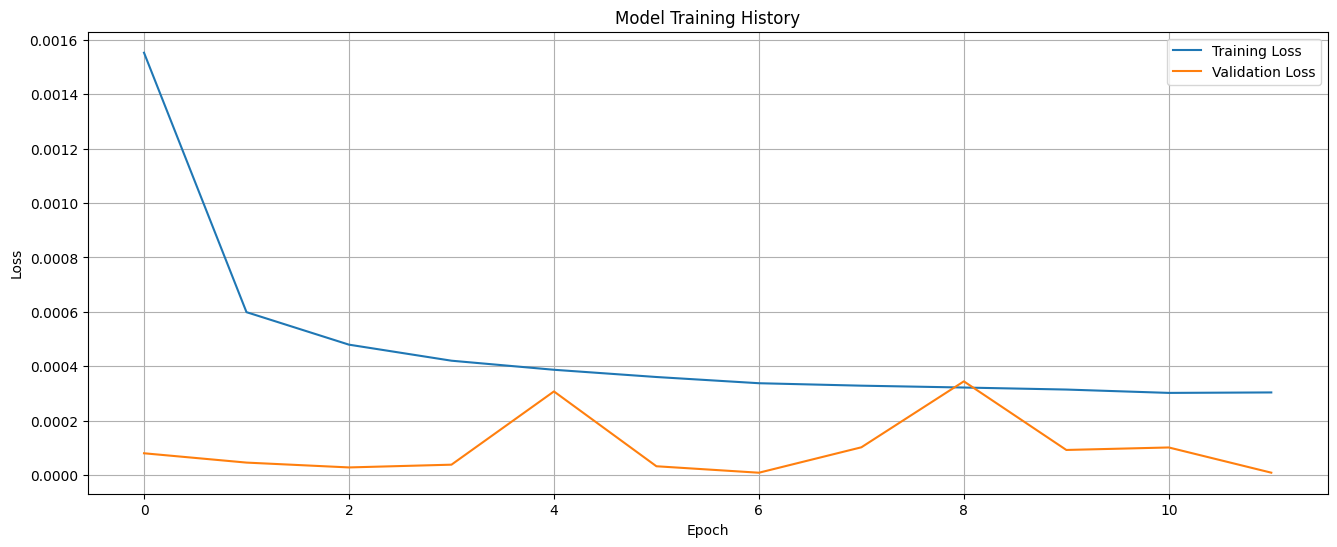

KeyError: 'accuracy'

<Figure size 1200x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='Training Loss')
# 绘制验证损失曲线（如果有验证集）
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 创建准确率曲线图（如果有准确率指标）
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy History')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()